# Efficient Economic Scenario Generation - Vectorised Numpy Approach

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import time
import jax
import jax.numpy as jnp
from cProfile import Profile


## The Numpy Approach

### Defining Our Model

In [5]:
def correlate_weiner_process(X, rho, dt):
    corr = np.array([[1,rho],[rho,1]])
    L = np.linalg.cholesky(corr)
    dZ = np.sqrt(dt)*(np.einsum('ij,ikl -> ikl',L,X))
    return dZ

def get_drift(x, alpha, mu, dt):
    return np.einsum('ij,ij -> ij', alpha, (mu-x)) * dt

def get_diffusion(x, sigma, dZ):
    return np.einsum('ij,ij->ij', np.einsum('ij,ij->ij',sigma,np.sqrt(x)),dZ)

def update(x, alpha, mu, sigma, dt, dZ):
    return x + get_drift(x, alpha, mu, dt) + get_diffusion(x, sigma, dZ)

def generate_processes(x0, dt, alpha, mu, sigma, dZ):
    x = np.zeros(dZ.shape)
    x[:, 0] = x0

    for i in range(1, 1200):
        x[:, i] = update(x[:, i-1], alpha, mu, sigma, dt, dZ[:, i-1])

        
    xt1 = np.sum(x,axis=0)
    phi = 0.045 - np.expand_dims(np.sum(x0,axis=0), axis=0)
    
    n = phi + xt1
    return n


### Setting Parameters

In [6]:
n_trials = 10000

n_years = 100
dt = 1/12
n_factors = 2
rho = 0.739

x0 = np.array([np.repeat(0.0228, n_trials),np.repeat(0.0809, n_trials)])
alpha = np.array([np.repeat(1.0682, n_trials), np.repeat(0.0469,n_trials)])
mu = np.array([np.repeat(0.0546, n_trials), np.repeat(0.0778, n_trials)])
sigma = np.array([np.repeat(0.0412, n_trials), np.repeat(0.0287, n_trials)])

### Generating Scenarios

In [7]:
key = jax.random.PRNGKey(57)
X = jax.random.normal(key=key, shape=(n_factors, int(n_years / dt), n_trials))


start = time.time()
dZ = correlate_weiner_process(X, rho, dt)
end1 = time.time()
print("Time taken for calculating Weiner process correlations: ", end1 - start)

Time taken for calculating Weiner process correlations:  0.3533594608306885


In [8]:
with Profile() as prof:
    n = generate_processes(x0, dt, alpha, mu, sigma, dZ)
    prof.print_stats(sort='tottime')

         29565 function calls (29557 primitive calls) in 0.232 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     3597    0.066    0.000    0.066    0.000 {built-in method numpy.core._multiarray_umath.c_einsum}
      2/1    0.040    0.020    0.229    0.229 3917983083.py:16(generate_processes)
     1199    0.030    0.000    0.051    0.000 3917983083.py:7(get_drift)
     1199    0.029    0.000    0.159    0.000 3917983083.py:13(update)
     1199    0.025    0.000    0.073    0.000 3917983083.py:10(get_diffusion)
      3/1    0.018    0.006    0.000    0.000 {method 'poll' of 'select.epoll' objects}
        2    0.017    0.009    0.017    0.009 {method 'reduce' of 'numpy.ufunc' objects}
    17985    0.002    0.000    0.002    0.000 einsumfunc.py:1001(_einsum_dispatcher)
     3597    0.001    0.000    0.068    0.000 einsumfunc.py:1009(einsum)
        1    0.001    0.001    0.006    0.006 decorator.py:229(fun)
        5    0.0

In [9]:
# plt.plot(n);

## The Jax Approach

In [10]:
# Check Jax uses GPU

print(jax.devices())

[cuda(id=0)]


### Defining Our Model

In [11]:
def correlate_weiner_process_jax(X, rho, dt):
    corr = jnp.array([[1,rho],[rho,1]])
    L = jnp.linalg.cholesky(corr)
    dZ = jnp.sqrt(dt)*jnp.tensordot(L, X, axes=([1],[0]))
    # dZ = jnp.sqrt(dt)*(jnp.einsum('ij,ikl -> jkl',L,X))
    return dZ

def get_drift_jax(x, alpha, mu, dt):
    # return jnp.einsum('ij,ij -> ij', alpha, (mu-x)) * dt
    return alpha * (mu - x) * dt

def get_diffusion_jax(x, sigma, dZ):
    # return jnp.einsum('ij,ij->ij', jnp.einsum('ij,ij->ij',sigma, jnp.sqrt(x)),dZ)
    return sigma * jnp.sqrt(x) * dZ

def update_jax(x, alpha, mu, sigma, dt, dZ):
    return x + get_drift_jax(x, alpha, mu, dt) + get_diffusion_jax(x, sigma, dZ)

def generate_processes_jax(x0, dt, alpha, mu, sigma, dZ):
    x = jnp.zeros(dZ.shape)
    x = x.at[:, 0].set(x0)

    update_jax_jit = jax.jit(update_jax)
    for i in range(1, dZ.shape[1]):
        x = x.at[:, i].set(update_jax_jit(x[:, i-1], alpha, mu, sigma, dt, dZ[:, i-1]))
        
    xt1 = jnp.sum(x,axis=0)
    phi = 0.045 - jnp.expand_dims(jnp.sum(x0,axis=0), axis=0)
    
    n = phi + xt1
    return n


### Setting Parameters

In [45]:
n_trials = 100_000

n_years = 100
dt = 1/12
n_factors = 2
rho = 0.739

x0 = jnp.array([jnp.repeat(0.0228, n_trials),jnp.repeat(0.0809, n_trials)])
alpha = jnp.array([jnp.repeat(1.0682, n_trials), jnp.repeat(0.0469,n_trials)])
mu = jnp.array([jnp.repeat(0.0546, n_trials), jnp.repeat(0.0778, n_trials)])
sigma = jnp.array([jnp.repeat(0.0412, n_trials), jnp.repeat(0.0287, n_trials)])

### Generating Scenarios

In [46]:
key = jax.random.PRNGKey(108)
X = jax.random.normal(key=key, shape=(n_factors, int(n_years / dt), n_trials))

correlate_weiner_process_jax_jit = jax.jit(correlate_weiner_process_jax)

start = time.time()
dZ = correlate_weiner_process_jax_jit(X, rho, dt).block_until_ready()
end1 = time.time()
print("Time taken for calculating Weiner process correlations: ", end1 - start)

2024-04-25 11:39:38.397550: W external/xla/xla/service/hlo_rematerialization.cc:2946] Can't reduce memory use below 3.28GiB (3519065080 bytes) by rematerialization; only reduced to 3.58GiB (3840000016 bytes), down from 3.58GiB (3840000016 bytes) originally


Time taken for calculating Weiner process correlations:  1.2597336769104004


In [47]:
# Profile the jax code with jax profiling
generate_processes_jax_jit = jax.jit(generate_processes_jax)

with Profile() as prof:
    n = generate_processes_jax_jit(x0, dt, alpha, mu, sigma, dZ)
    prof.print_stats(sort='tottime')

(1200, 10000)


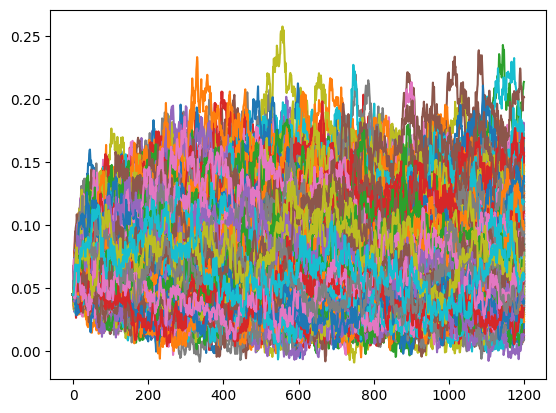

In [44]:
plt.plot(n[:, :1000]);